### CSE 5243 Introduction to Data Mining (SP18)
# Lab 2: k-Nearest Neighbors

Shuo Lin <lin.2237@osu.edu> by February 19 2018

Yuxiao Zhao <zhao.2379@osu.edu>  by February 19 2018

## Part 0. Get the data

The dataset used in this lab is [Adult dataset](https://archive.ics.uci.edu/ml/datasets/Adult) from [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php). The training dataset is *income_tr.csv* and the test dataset is *income_te.csv*

#### read the data

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [30]:
# read in the csv file
df_adult_tr = pd.read_csv('income_tr.csv',delimiter=',')
df_adult_te = pd.read_csv('income_te.csv',delimiter=',')

In [31]:
df_adult_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520 entries, 0 to 519
Data columns (total 16 columns):
ID                520 non-null int64
age               520 non-null int64
workclass         520 non-null object
fnlwgt            520 non-null int64
education         520 non-null object
education_cat     520 non-null int64
marital_status    520 non-null object
occupation        520 non-null object
relationship      520 non-null object
race              520 non-null object
gender            520 non-null object
capital_gain      520 non-null int64
capital_loss      520 non-null int64
hour_per_week     520 non-null int64
native_country    520 non-null object
class             520 non-null object
dtypes: int64(7), object(9)
memory usage: 65.1+ KB


In [32]:
# get rid of the space in the strings
for col in df_adult_tr.select_dtypes(include=['object']).columns.values.tolist():
    df_adult_tr[col] = df_adult_tr[col].str.strip()

for col in df_adult_te.select_dtypes(include=['object']).columns.values.tolist():
    df_adult_te[col] = df_adult_te[col].str.strip()

In [33]:
# replace "?" with nan
df_adult_tr = df_adult_tr.replace('?', np.nan)
df_adult_te = df_adult_te.replace('?', np.nan)

In [34]:
# summarize the number of missing values in each attribute
df_adult_tr.isnull().sum() 

ID                 0
age                0
workclass         28
fnlwgt             0
education          0
education_cat      0
marital_status     0
occupation        28
relationship       0
race               0
gender             0
capital_gain       0
capital_loss       0
hour_per_week      0
native_country     6
class              0
dtype: int64

In [35]:
df_adult_te.isnull().sum() 

ID                 0
age                0
workclass         20
fnlwgt             0
education          0
education_cat      0
marital_status     0
occupation        20
relationship       0
race               0
gender             0
capital_gain       0
capital_loss       0
hour_per_week      0
native_country     1
class              0
dtype: int64

## Part 1. Implement a custom proximity funciton

In [36]:
df_adult_tr.head()

,ID,age,workclass,fnlwgt,education,education_cat,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hour_per_week,native_country,class
0,9364,38,Private,197077,HS-grad,9,Married-civ-spouse,Other-service,Husband,White,Male,0,0,40,United-States,<=50K
1,25668,31,Private,101761,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,51,United-States,<=50K
2,13316,26,Private,152855,HS-grad,9,Never-married,Exec-managerial,Own-child,Other,Female,0,0,40,Mexico,<=50K
3,28750,50,Self-emp-not-inc,99894,5th-6th,3,Never-married,Tech-support,Not-in-family,Asian-Pac-Islander,Female,0,0,15,United-States,<=50K
4,30619,35,Private,412379,HS-grad,9,Never-married,Other-service,Not-in-family,White,Female,0,0,40,United-States,<=50K


In [37]:
# show the count, mean, std, min, max, percentile of these numeric attributes.
df_adult_tr[['age','education_cat','fnlwgt','hour_per_week','capital_gain','capital_loss']].describe()

,age,education_cat,fnlwgt,hour_per_week,capital_gain,capital_loss
count,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000
mean,38.388462,10.057692,187200.003846,39.575000,1065.994231,68.915385
std,13.911469,2.634538,100037.914197,12.202615,6822.672989,373.962942
min,17.000000,1.000000,26880.000000,2.000000,0.000000,0.000000
25%,27.000000,9.000000,116385.500000,38.000000,0.000000,0.000000
50%,36.000000,10.000000,176939.000000,40.000000,0.000000,0.000000
75%,47.250000,12.000000,237372.750000,42.000000,0.000000,0.000000
max,82.000000,16.000000,632613.000000,99.000000,99999.000000,4356.000000


In [38]:
# show the count, mean, std, min, max, percentile of these numeric attributes.
df_adult_te[['age','education_cat','fnlwgt','hour_per_week','capital_gain','capital_loss']].describe()

,age,education_cat,fnlwgt,hour_per_week,capital_gain,capital_loss
count,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000
mean,38.496528,10.177083,196860.743056,41.548611,561.048611,78.274306
std,13.332259,2.452311,112502.987868,13.578180,6001.243766,378.187901
min,17.000000,3.000000,25497.000000,2.000000,0.000000,0.000000
25%,27.000000,9.000000,116972.250000,40.000000,0.000000,0.000000
50%,36.000000,10.000000,183426.000000,40.000000,0.000000,0.000000
75%,48.250000,13.000000,255305.750000,48.000000,0.000000,0.000000
max,76.000000,16.000000,672412.000000,99.000000,99999.000000,2415.000000


Final weight in testing dataset has larger maximum of final weight than training dataset does. So we will use the maximum of final weight in testing dataset for computing similarity of final weight.

In [39]:
# the range of the numeric attribute in the dataset
range_ = pd.Series()
range_['age'] = df_adult_tr.loc[:,'age'].max(axis=0) - df_adult_tr.loc[:,'age'].min(axis=0)
range_['hour_per_week'] = df_adult_tr.loc[:,'hour_per_week'].max(axis=0) - df_adult_tr.loc[:,'hour_per_week'].min(axis=0)
range_['capital_gain'] = df_adult_tr.loc[:,'capital_gain'].max(axis=0) - df_adult_tr.loc[:,'capital_gain'].min(axis=0)
range_['capital_loss'] = df_adult_tr.loc[:,'capital_loss'].max(axis=0) - df_adult_tr.loc[:,'capital_loss'].min(axis=0)
range_['education_cat'] = df_adult_tr.loc[:,'education_cat'].max(axis=0) - df_adult_tr.loc[:,'education_cat'].min(axis=0)
range_['fnlwgt'] = df_adult_te.loc[:,'fnlwgt'].max(axis=0) - df_adult_tr.loc[:,'fnlwgt'].min(axis=0)  # use the value of the maximum of the testing dataset instead

In [40]:
# proximity between two rows, output a single value of the proximity
# row1 and row2 are different rows in the dataset
def row_proximity(row1,row2):
    num_col = ['age','education_cat','capital_gain','capital_loss','hour_per_week','fnlwgt']
    obj_col = ['workclass','marital_status','occupation','relationship','race','gender','native_country']
    prox=[]
    # proximity for 'age','education_cat','capital_gain','capital_loss','hour_per_week','fnlwgt'
    for c in num_col:
        prox.append(1 - abs(row1[c] - row2[c])/range_[c])
    
    # proximity for 'workclass','marital_status','occupation','relationship','race','gender','native_country'
    # need to exclude the NaN value
    for c in obj_col:
        if pd.isnull(row1[c]) or pd.isnull(row2[c]):
            prox.append(np.nan)
        elif row1[c] == row2[c]:
            prox.append(1)
        else:
            prox.append(0)
        
    # total proximity
    prox_total = np.nansum(prox)/(len(prox) - np.isnan(prox).sum()) # need to exclude Nan value in the calculation
    return(prox_total)

In [41]:
# test
row_proximity(df_adult_tr.iloc[19],df_adult_tr.iloc[224])

0.85864460089609695

In [42]:
# a funciton to generate the column names in the output table
def col(p):
    for q in range(1,p+1):
        yield '%d-ID'%q
        yield '%d-prox'%q

In [43]:
# proximity function, input the dataset and k, output every record ID with its most k similar record IDs in the training dataset and proximities
# In the part 1, we use training dataset as the input, calculating the similarity with itself
def proximity(df, k=5):
    proximity = pd.DataFrame(df.loc[:,'ID'], columns = ['ID'] + list(col(k)) ) # the output dataframe    
    for i in range(len(df.index)):
        sim = np.zeros(shape=(len(df_adult_tr.index)))
        for j in range(len(df_adult_tr.index)):
            if df.loc[i,'ID'] != df_adult_tr.loc[j,'ID']:
                sim[j] = row_proximity(df.iloc[i],df_adult_tr.iloc[j])                
        ksim_idx  = sim.argsort()[0-k:][::-1]  # the index of the rows which have the k highest similarities
        for n in range(k):
            proximity.loc[i,'%d-ID'%(n+1)] = df_adult_tr.loc[ksim_idx[n],'ID'] # the ID of the (n+1)th closest record (n from 0 to k-1)
            proximity.loc[i,'%d-prox'%(n+1)] = sim[ksim_idx[n]] # the similarity of the (n+1)th closet record
    return(proximity)

In [44]:
adult_proximity = proximity(df_adult_tr)
adult_proximity.head()

,ID,1-ID,1-prox,2-ID,2-prox,3-ID,3-prox,4-ID,4-prox,5-ID,5-prox
0,9364,21538,0.979059,31329,0.971307,8644,0.970931,24931,0.969623,22379,0.946279
1,25668,18839,0.975953,20406,0.974695,12510,0.974385,24514,0.973418,7578,0.973345
2,13316,1589,0.823613,18754,0.797346,21699,0.789152,5303,0.7872,6996,0.782731
3,28750,14575,0.774076,9873,0.75553,8581,0.752632,27467,0.744597,25132,0.740098
4,30619,25495,0.958503,12171,0.949686,31260,0.944202,8917,0.942266,18540,0.900801


In [45]:
adult_proximity.to_csv('output_part1.csv', sep=',', encoding='utf-8')

# Part 2: Implement kNN Classifier

In [46]:
adult_te_proximity = proximity(df_adult_te)
adult_te_proximity.head()

,ID,1-ID,1-prox,2-ID,2-prox,3-ID,3-prox,4-ID,4-prox,5-ID,5-prox
0,2905,24931,0.957289,31329,0.95345,8644,0.935532,9364,0.932688,21538,0.905026
1,6846,27467,0.946443,5157,0.932209,14575,0.916965,4005,0.881725,9734,0.873875
2,23873,21538,0.889084,8644,0.870699,26349,0.867656,25398,0.848569,21825,0.847424
3,27746,21538,0.965614,8644,0.957486,21059,0.951174,1891,0.949147,21776,0.948449
4,25673,32313,0.812667,24752,0.759932,30625,0.756979,3343,0.756575,2327,0.755813


In [47]:
def knnClassifier(df,k=5,t=0.5):
    knn = pd.DataFrame(df.loc[:,'ID'], columns = ['ID','ActualClass','PredictedClass','PosteriorPossibility'])
    adult_te_proximity = proximity(df,k)
    for i in range(len(df.index)):
        ID = df.loc[i,'ID'] # get the id from df
        actual = df_adult_te.loc[df_adult_te['ID'] == ID, 'class'] # get the class value by using ID from test data
        actualClass = actual.item()
        
        classes = [' ']*k
        
        for n in range (k):
            neededID = '%d-ID'%(n+1)
            trueID = adult_te_proximity.loc[adult_te_proximity['ID'] == ID, neededID].item()
            trueClass = df_adult_tr.loc[df_adult_tr['ID'] == trueID, 'class'].item()
            classes[n] = trueClass
        
        predictedClass = [' ']
        greater50K = 0
        less50K = 0
        
        for x in range (len(classes)):
            if (classes[x] == '>50K' ):
                greater50K = greater50K + 1
        
        postProb = float(greater50K) / k
        if postProb > t :
            predictedClass = '>50K'
        else:
            predictedClass = '<=50K'
    
        knn.loc[i,'ID'] = ID
        knn.loc[i,'ActualClass'] = actualClass
        knn.loc[i,'PredictedClass'] = predictedClass
        knn.loc[i,'PosteriorPossibility'] = postProb
        
    return (knn)
    

In [48]:
knn = knnClassifier(df_adult_te)
knn.head(10)

,ID,ActualClass,PredictedClass,PosteriorPossibility
0,2905,<=50K,<=50K,0.2
1,6846,<=50K,<=50K,0.2
2,23873,>50K,<=50K,0.4
3,27746,<=50K,<=50K,0.4
4,25673,<=50K,<=50K,0
5,10811,<=50K,<=50K,0
6,2675,<=50K,<=50K,0
7,9296,<=50K,<=50K,0.2
8,7733,>50K,<=50K,0.2
9,12547,>50K,>50K,1


In [49]:
knn = knnClassifier(df_adult_te,k=8,t=0.6)
knn.head(10)

,ID,ActualClass,PredictedClass,PosteriorPossibility
0,2905,<=50K,<=50K,0.25
1,6846,<=50K,<=50K,0.125
2,23873,>50K,<=50K,0.375
3,27746,<=50K,<=50K,0.5
4,25673,<=50K,<=50K,0
5,10811,<=50K,<=50K,0
6,2675,<=50K,<=50K,0
7,9296,<=50K,<=50K,0.125
8,7733,>50K,<=50K,0.375
9,12547,>50K,>50K,0.875


In [50]:
knn.to_csv('output_part2.csv', sep=',', encoding='utf-8')

In [51]:
from sklearn.metrics import confusion_matrix

def knnEvaluation(knn):
    
    y_true = [' '] * len(knn.index)
    y_pred = [' '] * len(knn.index)

    for i in range(len(knn.index)):
        y_true[i] = knn.loc[i,'ActualClass']
        y_pred[i] = knn.loc[i,'PredictedClass']

    conf_matrix = confusion_matrix(y_true, y_pred, labels=[">50K", "<=50K"])

    tn = conf_matrix[0,0]
    fp = conf_matrix[0,1]
    fn = conf_matrix[1,0]
    tp = conf_matrix[1,1]
    print('confusion matrix:\n',[[tp,fp],[fn,tn]])
    accuracy = (tp + tn)/ (tp + fp + fn + tn)
    error_rate = 1 - accuracy
    tpr = tp / (tp + fn)
    tnr = tn / (fp + tn)
    fpr = fp / (fp + tn)
    fnr = fn / (fn + tp)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1score = 2 * tp / (tp + fp + tp + fn)
    # based on the positive class (class=1)
    print('accuracy:   %f'%accuracy)
    print('error_rate:%f'%error_rate)

    print('true positve rate:    %f'%tpr)
    print('true negative rate:%f'%tnr)
    print('false positve rate:    %f'%fpr)
    print('false negative rate:%f'%fnr)

    print('precision:%f'%precision)
    print('recall:%f'%recall)
    print('F1 score:%f'%f1score)
    
knnEvaluation(knn)

confusion matrix:
 [[209, 51], [12, 16]]
accuracy:   0.781250
error_rate:0.218750
true positve rate:    0.945701
true negative rate:0.238806
false positve rate:    0.761194
false negative rate:0.054299
precision:0.803846
recall:0.945701
F1 score:0.869023


|Condition Positive|Condition Negative
:---:|:---:|:---:
Outcome Positive|True Positive:209|False Positive:51
Outcome Negative|False Negative:12|True Negative:16

* accuracy:0.781250, error_rate:0.218750
* true positve rate:0.945701, true negative rate:0.238806, false positve rate:0.761194, false negative rate:0.054299
* precision:0.803846, recall:0.945701, F1 score:0.869023

# Exceptional Work

In [52]:
knn_sorted = knn.sort_values('PosteriorPossibility', ascending=False)
knn_sorted.head()

,ID,ActualClass,PredictedClass,PosteriorPossibility
101,4333,<=50K,>50K,0.875
259,7685,<=50K,>50K,0.875
221,21200,<=50K,>50K,0.875
151,30344,>50K,>50K,0.875
163,17552,>50K,>50K,0.875


In [53]:
def toClass(b, t=0.5):
    return('pos' if b>=t else 'neg')

In [54]:
cp = sum(knn_sorted['ActualClass'] == '>50K')
cn = sum(knn_sorted['ActualClass'] == '<=50K')
X = [0] # store results for plotting
Y = [0] # " " "
AUC = 0.0
lastfpr = 0.0
for threshold in knn_sorted['PosteriorPossibility']:
    out = knn_sorted['PosteriorPossibility'].apply(toClass, t=threshold)
    tp = sum((knn_sorted['ActualClass'] == '>50K') & (out == 'pos'))
    tn = sum((knn_sorted['ActualClass'] == '<=50K') & (out == 'neg'))
    fp = sum((knn_sorted['ActualClass'] == '<=50K') & (out == 'pos'))
    fn = sum((knn_sorted['ActualClass'] == '>50K') & (out == 'neg'))
    tpr = tp / cp # recall
    fpr = fp / cn # fallout
    X.extend([fpr])
    Y.extend([tpr])
    print("t=%.2f: TP=%d, TN=%d, FP=%d, FN=%d, TPR=%.2f, FPR=%.2f" % (threshold, tp, tn, fp, fn, tpr, fpr))
    AUC = AUC + ((fpr-lastfpr)*tpr)
    lastfpr = fpr
X.extend([1])
Y.extend([1])
print("AUC: %.2f" % AUC)

t=0.88: TP=4, TN=218, FP=3, FN=63, TPR=0.06, FPR=0.01
t=0.88: TP=4, TN=218, FP=3, FN=63, TPR=0.06, FPR=0.01
t=0.88: TP=4, TN=218, FP=3, FN=63, TPR=0.06, FPR=0.01
t=0.88: TP=4, TN=218, FP=3, FN=63, TPR=0.06, FPR=0.01
t=0.88: TP=4, TN=218, FP=3, FN=63, TPR=0.06, FPR=0.01
t=0.88: TP=4, TN=218, FP=3, FN=63, TPR=0.06, FPR=0.01
t=0.88: TP=4, TN=218, FP=3, FN=63, TPR=0.06, FPR=0.01
t=0.75: TP=14, TN=215, FP=6, FN=53, TPR=0.21, FPR=0.03
t=0.75: TP=14, TN=215, FP=6, FN=53, TPR=0.21, FPR=0.03
t=0.75: TP=14, TN=215, FP=6, FN=53, TPR=0.21, FPR=0.03
t=0.75: TP=14, TN=215, FP=6, FN=53, TPR=0.21, FPR=0.03
t=0.75: TP=14, TN=215, FP=6, FN=53, TPR=0.21, FPR=0.03
t=0.75: TP=14, TN=215, FP=6, FN=53, TPR=0.21, FPR=0.03
t=0.75: TP=14, TN=215, FP=6, FN=53, TPR=0.21, FPR=0.03
t=0.75: TP=14, TN=215, FP=6, FN=53, TPR=0.21, FPR=0.03
t=0.75: TP=14, TN=215, FP=6, FN=53, TPR=0.21, FPR=0.03
t=0.75: TP=14, TN=215, FP=6, FN=53, TPR=0.21, FPR=0.03
t=0.75: TP=14, TN=215, FP=6, FN=53, TPR=0.21, FPR=0.03
t=0.75: TP=14, TN

t=0.00: TP=67, TN=0, FP=221, FN=0, TPR=1.00, FPR=1.00
t=0.00: TP=67, TN=0, FP=221, FN=0, TPR=1.00, FPR=1.00
t=0.00: TP=67, TN=0, FP=221, FN=0, TPR=1.00, FPR=1.00
t=0.00: TP=67, TN=0, FP=221, FN=0, TPR=1.00, FPR=1.00
t=0.00: TP=67, TN=0, FP=221, FN=0, TPR=1.00, FPR=1.00
t=0.00: TP=67, TN=0, FP=221, FN=0, TPR=1.00, FPR=1.00
t=0.00: TP=67, TN=0, FP=221, FN=0, TPR=1.00, FPR=1.00
t=0.00: TP=67, TN=0, FP=221, FN=0, TPR=1.00, FPR=1.00
t=0.00: TP=67, TN=0, FP=221, FN=0, TPR=1.00, FPR=1.00
t=0.00: TP=67, TN=0, FP=221, FN=0, TPR=1.00, FPR=1.00
t=0.00: TP=67, TN=0, FP=221, FN=0, TPR=1.00, FPR=1.00
t=0.00: TP=67, TN=0, FP=221, FN=0, TPR=1.00, FPR=1.00
t=0.00: TP=67, TN=0, FP=221, FN=0, TPR=1.00, FPR=1.00
t=0.00: TP=67, TN=0, FP=221, FN=0, TPR=1.00, FPR=1.00
t=0.00: TP=67, TN=0, FP=221, FN=0, TPR=1.00, FPR=1.00
t=0.00: TP=67, TN=0, FP=221, FN=0, TPR=1.00, FPR=1.00
t=0.00: TP=67, TN=0, FP=221, FN=0, TPR=1.00, FPR=1.00
t=0.00: TP=67, TN=0, FP=221, FN=0, TPR=1.00, FPR=1.00
t=0.00: TP=67, TN=0, FP=221,

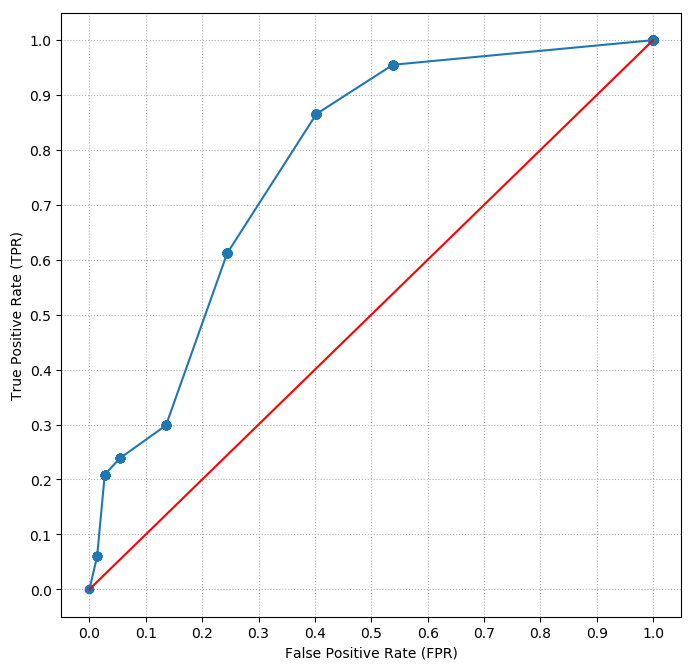

In [55]:
# ROC curve
plt.figure(figsize=(8,8), dpi=100)
plt.plot(X, Y, marker='o')
plt.plot([0,1], [0,1], c='red') # red reference line
plt.xticks(np.arange(0,1.1,0.1))
plt.yticks(np.arange(0,1.1,0.1))
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.grid(linestyle='dotted')
plt.axis(xmin=-0.05, xmax=1.05, ymin=-0.05, ymax=1.05)
plt.show()

Run your kNN classifier with at least 5 different values of k and summarize your findings. Which value of k works best? Justify your conclusion.

In [57]:
# k = 3
knn = knnClassifier(df_adult_te,k=3,t=0.6)
knnEvaluation(knn)


confusion matrix:
 [[185, 44], [36, 23]]
accuracy:   0.722222
error_rate:0.277778
true positve rate:    0.837104
true negative rate:0.343284
false positve rate:    0.656716
false negative rate:0.162896
precision:0.807860
recall:0.837104
F1 score:0.822222


In [63]:
# k = 5
knn = knnClassifier(df_adult_te,k=5,t=0.6)
knnEvaluation(knn)


confusion matrix:
 [[215, 56], [6, 11]]
accuracy:   0.784722
error_rate:0.215278
true positve rate:    0.972851
true negative rate:0.164179
false positve rate:    0.835821
false negative rate:0.027149
precision:0.793358
recall:0.972851
F1 score:0.873984


In [58]:
# k = 6 
knn = knnClassifier(df_adult_te,k=6,t=0.6)
knnEvaluation(knn)


confusion matrix:
 [[209, 52], [12, 15]]
accuracy:   0.777778
error_rate:0.222222
true positve rate:    0.945701
true negative rate:0.223881
false positve rate:    0.776119
false negative rate:0.054299
precision:0.800766
recall:0.945701
F1 score:0.867220


In [59]:
# k = 7 
knn = knnClassifier(df_adult_te,k=7,t=0.6)
knnEvaluation(knn)


confusion matrix:
 [[214, 52], [7, 15]]
accuracy:   0.795139
error_rate:0.204861
true positve rate:    0.968326
true negative rate:0.223881
false positve rate:    0.776119
false negative rate:0.031674
precision:0.804511
recall:0.968326
F1 score:0.878850


In [60]:
# k = 9 
knn = knnClassifier(df_adult_te,k=9,t=0.6)
knnEvaluation(knn)


confusion matrix:
 [[211, 53], [10, 14]]
accuracy:   0.781250
error_rate:0.218750
true positve rate:    0.954751
true negative rate:0.208955
false positve rate:    0.791045
false negative rate:0.045249
precision:0.799242
recall:0.954751
F1 score:0.870103


In [61]:
# k = 13
knn = knnClassifier(df_adult_te,k=13,t=0.6)
knnEvaluation(knn)


confusion matrix:
 [[208, 54], [13, 13]]
accuracy:   0.767361
error_rate:0.232639
true positve rate:    0.941176
true negative rate:0.194030
false positve rate:    0.805970
false negative rate:0.058824
precision:0.793893
recall:0.941176
F1 score:0.861284


In [62]:
# k = 21
knn = knnClassifier(df_adult_te,k=21,t=0.6)
knnEvaluation(knn)


confusion matrix:
 [[214, 56], [7, 11]]
accuracy:   0.781250
error_rate:0.218750
true positve rate:    0.968326
true negative rate:0.164179
false positve rate:    0.835821
false negative rate:0.031674
precision:0.792593
recall:0.968326
F1 score:0.871690


In [64]:
# k = 49
knn = knnClassifier(df_adult_te,k=49,t=0.6)
knnEvaluation(knn)


confusion matrix:
 [[221, 65], [0, 2]]
accuracy:   0.774306
error_rate:0.225694
true positve rate:    1.000000
true negative rate:0.029851
false positve rate:    0.970149
false negative rate:0.000000
precision:0.772727
recall:1.000000
F1 score:0.871795


In [65]:
# k = 71
knn = knnClassifier(df_adult_te,k=71,t=0.6)
knnEvaluation(knn)


confusion matrix:
 [[221, 67], [0, 0]]
accuracy:   0.767361
error_rate:0.232639
true positve rate:    1.000000
true negative rate:0.000000
false positve rate:    1.000000
false negative rate:0.000000
precision:0.767361
recall:1.000000
F1 score:0.868369


As k increased, both the true positive rate and false positive rates incresaed as well. From our samples with k=49 and k=71, we can see that true positive rate reaches 1.0 before the false positive rate does. This indicates that when k increases, the number of objects being classified as negative(both true and false) increases. And when k reaches a certain value, all the obejcts in the data will be classifed as positive which explaines why no objects are being classified as negative. As the value of k increases beyond a certain range, the error rate starts to increase as well since we all essentially declaring more and more objects to be positive. The reason why this happens is as we increase k, we are basically increase the number of distant neighbors(objects with lower similarities). These neibors might belong to other classes since some of them might be quite different from the object that we are trying to classify. 

The best value for k, in my opinion, would be 7. The accuracy increases with k until k reaches 7. Error rate of k=7 is the lowest amongst all samples. In additon, the sum of the true postives and the true negatives are the greatest. 